In [49]:
import torch
import numpy as np 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [50]:
latent_dim = 5
batch_size = 1500
epochs = 50
update_freq = min(4, 10) #weight uypdates after freq iterations
beta = 0.000001

In [51]:


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        # Output both mean and log variance for the latent space
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        # Apply reparameterization trick
        std = torch.exp(0.5 * log_var)  # Standard deviation
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z, mean, log_var  # Return mean and log_var for loss calculation
   
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)  # Adjust to use full latent_dim
        self.fc2 = nn.Linear(128, 9216)
        self.convtrans1 = nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1)  
        self.convtrans2 = nn.ConvTranspose2d(32, 1, 3, stride=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, 12, 12)
        x = F.relu(self.convtrans1(x))
        x = torch.sigmoid(self.convtrans2(x))  # Use sigmoid to normalize output to [0, 1]
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mean, log_var = self.encoder(x)
        return self.decoder(z), mean, log_var  # Return reconstructed image, mean, and log_var

# Example usage
x = torch.randn(1, 1, 28, 28)
model = VAE()
reconstructed, mean, log_var = model(x)
print(reconstructed.shape, mean.shape, log_var.shape)  

torch.Size([1, 1, 28, 28]) torch.Size([1, 5]) torch.Size([1, 5])


In [52]:

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2,batch_size=batch_size, shuffle=True)    

def imshow(img: torch.Tensor):
    """
    Displays an MNIST image.

    Parameters:
    img (torch.Tensor): A PyTorch tensor of the image to display. 
                        Expected shape is (1, 28, 28) for a single image.
    """
    # Check if the image tensor seems to be in the (C, H, W) format and has 1 channel (grayscale)
    if img.shape[0] == 1:
        img = img.squeeze(0)  # Remove the channel dimension if it's a single-channel image
    plt.imshow(img, cmap='gray')  # Display the image in grayscale
    plt.axis('off')  # Optional: Do not display axis for cleaner visualization
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, verbose=True)
mse = nn.MSELoss()
def kl_divergence_loss(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

loss_history = []
update = 10

Epoch 1
Loss: 0.6450, divergence: 0.0193, total: 0.6643
Loss: 0.6436, divergence: 0.0192, total: 0.6628
Loss: 0.6430, divergence: 0.0185, total: 0.6615
Loss: 0.6366, divergence: 0.0177, total: 0.6543
Loss: 0.6452, divergence: 0.0185, total: 0.6637
Loss: 0.6374, divergence: 0.0182, total: 0.6556
Loss: 0.6367, divergence: 0.0182, total: 0.6550
Loss: 0.6411, divergence: 0.0186, total: 0.6598
Loss: 0.6425, divergence: 0.0188, total: 0.6613
Loss: 0.6420, divergence: 0.0191, total: 0.6611
Epoch 2
Loss: 0.6395, divergence: 0.0197, total: 0.6592
Loss: 0.6412, divergence: 0.0189, total: 0.6601
Loss: 0.6339, divergence: 0.0185, total: 0.6524
Loss: 0.6310, divergence: 0.0183, total: 0.6493
Loss: 0.6443, divergence: 0.0193, total: 0.6636
Loss: 0.6408, divergence: 0.0192, total: 0.6601
Loss: 0.6459, divergence: 0.0188, total: 0.6647
Loss: 0.6404, divergence: 0.0180, total: 0.6584
Loss: 0.6406, divergence: 0.0183, total: 0.6589
Loss: 0.6321, divergence: 0.0196, total: 0.6517
Epoch 3
Loss: 0.6370, di

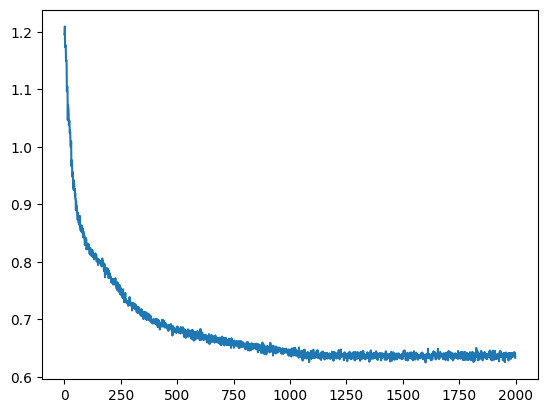

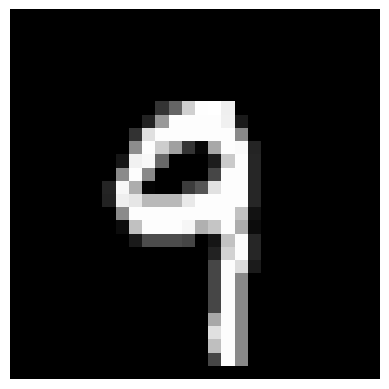

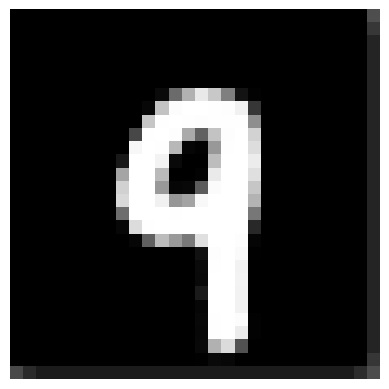

In [57]:

for epoch in range(epochs):
    model.train()
    print(f'Epoch {epoch+1}')
    for img, label in train_loader:
        img = img.to(device)
        output, mean, log_var = model(img)
        loss = mse(output, img)
        divergence = kl_divergence_loss(mean, log_var) * beta
        total_loss = loss + divergence
        total_loss.backward()

        if update % update_freq == 0:
            print(f'Loss: {loss.item():.4f}, divergence: {divergence.item():.4f}, total: {total_loss.item():.4f}')
            optimizer.step()
            scheduler.step(loss)
            optimizer.zero_grad()
        loss_history.append(loss.item())
        update += 1




plt.plot(loss_history)
plt.show()
imshow(img[0].cpu())
imshow(output[0].cpu().detach())


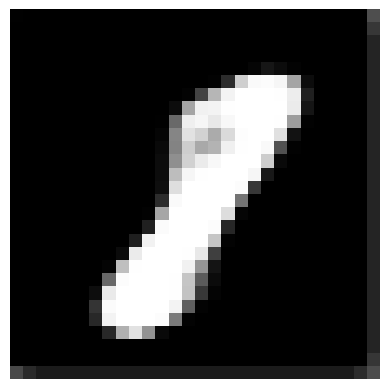

In [58]:
def sample_vae(model, num_samples=1, latent_dim=latent_dim):
    model.eval()
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        # Decode the sampled latent vectors
        generated_images = model.decoder(z)
    return generated_images
imshow(sample_vae(model, num_samples=1)[0].cpu().detach())

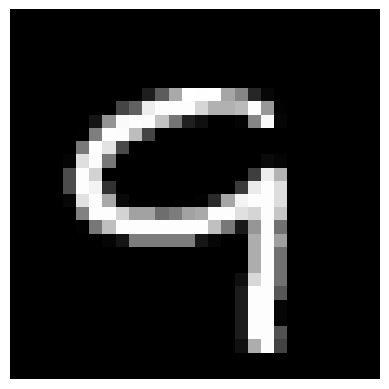

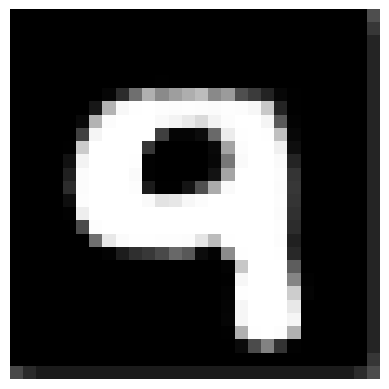

tensor(9)


In [82]:
for img, label in test_loader:
    img = img.to(device)
    output, m, v = model(img)
    imshow(img[0].cpu())
    imshow(output[0].cpu().detach())
    print(label[0])
    break

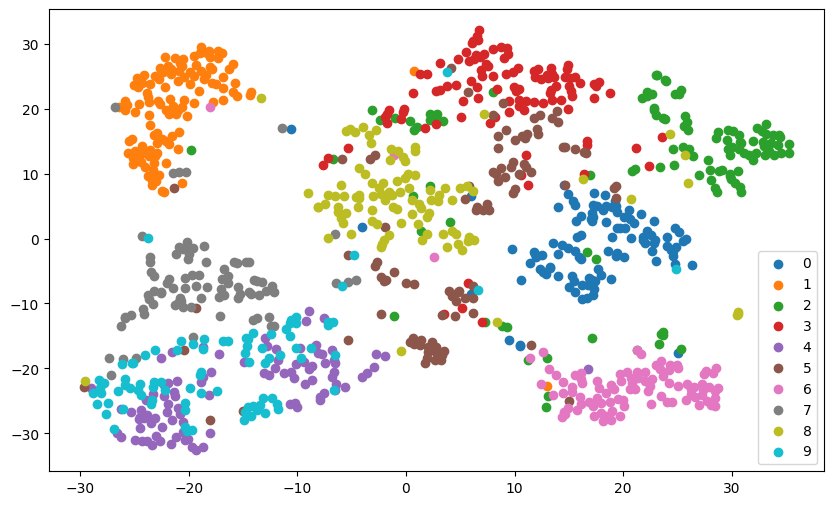

In [62]:

def visualize_latent_space(encoder, data_loader, num_samples=1000):
    encoder.eval()
    samples, labels = next(iter(data_loader))
    with torch.no_grad():
        encoded, _, _ = encoder(samples.to(device)[:num_samples])
    encoded = encoded.cpu().numpy()
    labels = labels.numpy()[:num_samples]
    
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded)
    
    plt.figure(figsize=(10, 6))
    for i in range(10):  # Assuming 10 classes
        idxs = labels == i
        plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=str(i))
    plt.legend()
    plt.show()

# Example usage with your VAE encoder and a data loader
visualize_latent_space(model.encoder, test_loader)
